
Basic Statistics:
Fear/Greed data shape: (2644, 5)
Trader data shape: (211224, 17)
Merged data shape: (211218, 21)

ANOVA Results: F-stat=6.08, p-value=0.0023


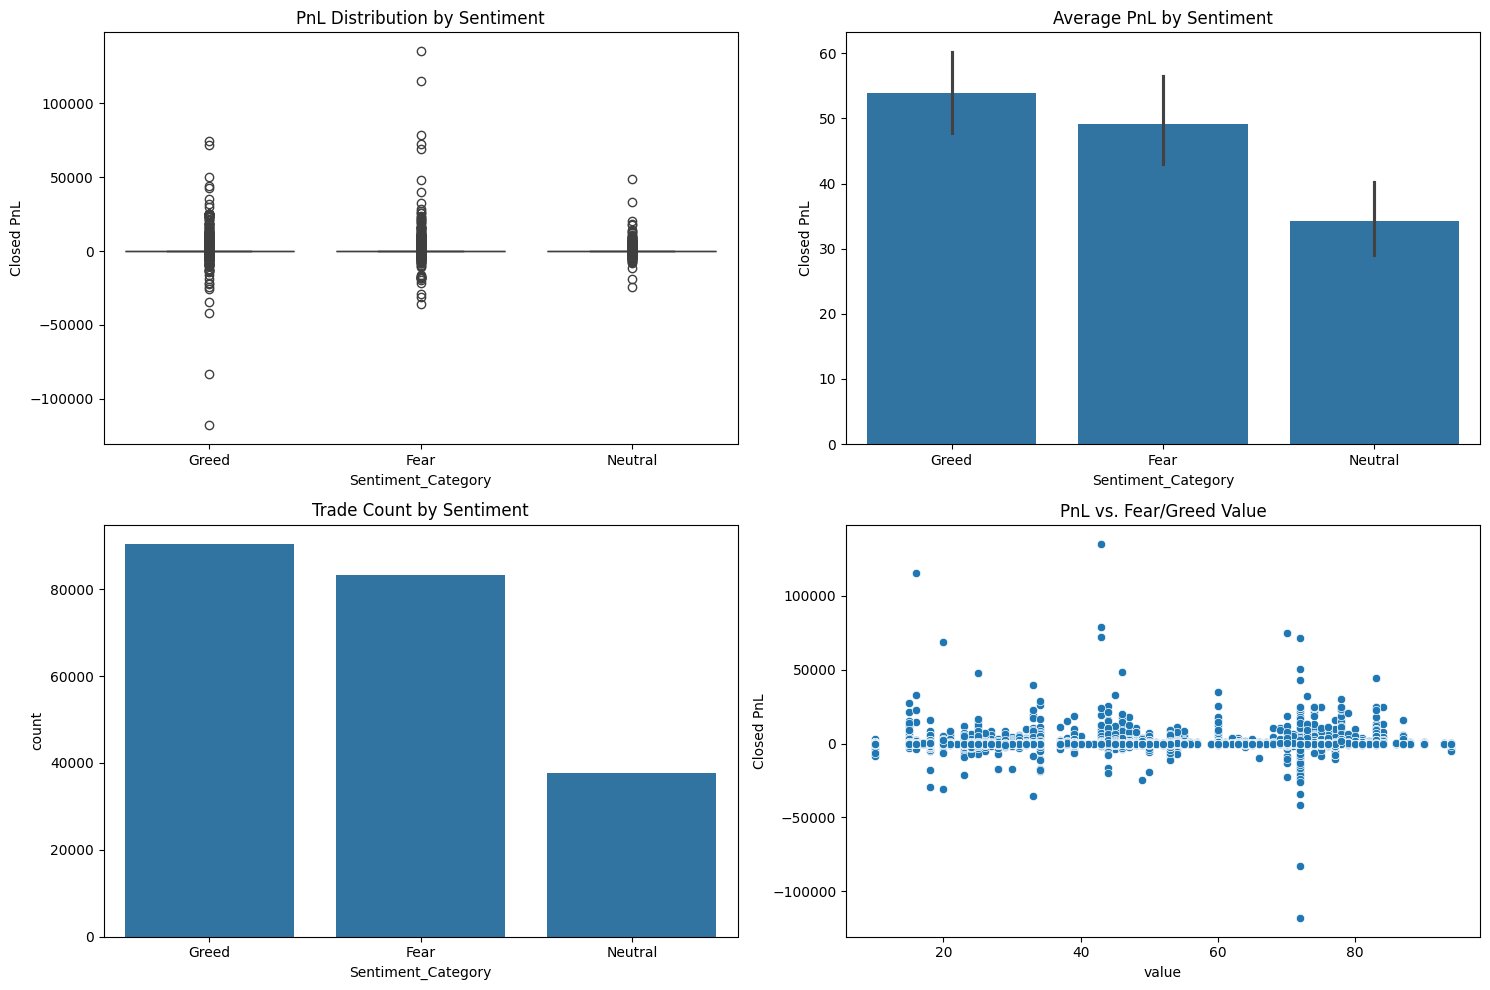


Analysis Report
Period: 2023-01-05 to 2025-12-04
Total Trades: 211,218
Unique Traders: 32

Key Findings:
1. Performance by Sentiment:
   - Fear: Avg PnL $49.21
   - Greed: Avg PnL $53.88
   - Neutral: Avg PnL $34.31

2. Statistical Significance:
   - Significant difference between sentiment groups (p=0.0023)

Recommendations:
- Focus on top performers in each sentiment category
- Analyze strategies of consistent performers
- Consider sentiment when evaluating trader performance



In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import warnings
warnings.filterwarnings('ignore')

# Load datasets
fear_greed = pd.read_csv('C:\\Users\\hp\\Downloads\\fear_greed_index.csv')
trader_data = pd.read_csv('C:\\Users\\hp\\Downloads\\historical_data.csv')

# Data Cleaning
# Convert date columns and standardize names
fear_greed['date'] = pd.to_datetime(fear_greed['date'])
trader_data['Timestamp IST'] = pd.to_datetime(trader_data['Timestamp IST'])

# Extract date from trader data
trader_data['date'] = trader_data['Timestamp IST'].dt.date
trader_data['date'] = pd.to_datetime(trader_data['date'])

# Clean sentiment classifications
fear_greed['classification'] = fear_greed['classification'].str.strip().str.title()

# Create sentiment categories
def categorize_sentiment(value):
    value = str(value).strip().title()
    if value in ['Extreme Fear', 'Fear']:
        return 'Fear'
    elif value in ['Extreme Greed', 'Greed']:
        return 'Greed'
    else:
        return 'Neutral'

fear_greed['Sentiment_Category'] = fear_greed['classification'].apply(categorize_sentiment)

# Merge datasets
merged_data = pd.merge(trader_data, fear_greed, on='date', how='left')
merged_data = merged_data.dropna(subset=['classification'])

# EDA: Basic Statistics
print("\nBasic Statistics:")
print("Fear/Greed data shape:", fear_greed.shape)
print("Trader data shape:", trader_data.shape)
print("Merged data shape:", merged_data.shape)

# Performance Analysis
def calculate_metrics(group):
    return pd.Series({
        'total_trades': group['Closed PnL'].count(),
        'total_pnl': group['Closed PnL'].sum(),
        'win_rate': (group['Closed PnL'] > 0).mean(),
        'avg_win': group[group['Closed PnL'] > 0]['Closed PnL'].mean(),
        'avg_loss': group[group['Closed PnL'] <= 0]['Closed PnL'].mean(),
        'profit_factor': abs(group[group['Closed PnL'] > 0]['Closed PnL'].sum() / 
                           group[group['Closed PnL'] <= 0]['Closed PnL'].sum()),
        'max_drawdown': group['Closed PnL'].cumsum().min(),
        'sharpe_ratio': group['Closed PnL'].mean() / (group['Closed PnL'].std() or 1) * np.sqrt(252)
    })

# Group by trader and sentiment
trader_performance = merged_data.groupby(['Account', 'Sentiment_Category']).apply(calculate_metrics).reset_index()

# Statistical Tests
fear_pnl = merged_data[merged_data['Sentiment_Category'] == 'Fear']['Closed PnL']
greed_pnl = merged_data[merged_data['Sentiment_Category'] == 'Greed']['Closed PnL']
neutral_pnl = merged_data[merged_data['Sentiment_Category'] == 'Neutral']['Closed PnL']

f_stat, p_value = stats.f_oneway(fear_pnl, greed_pnl, neutral_pnl)
print(f"\nANOVA Results: F-stat={f_stat:.2f}, p-value={p_value:.4f}")

# Visualization
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
sns.boxplot(x='Sentiment_Category', y='Closed PnL', data=merged_data)
plt.title('PnL Distribution by Sentiment')

plt.subplot(2, 2, 2)
sns.barplot(x='Sentiment_Category', y='Closed PnL', data=merged_data, estimator=np.mean)
plt.title('Average PnL by Sentiment')

plt.subplot(2, 2, 3)
sns.countplot(x='Sentiment_Category', data=merged_data)
plt.title('Trade Count by Sentiment')

plt.subplot(2, 2, 4)
sns.scatterplot(x='value', y='Closed PnL', data=merged_data)
plt.title('PnL vs. Fear/Greed Value')
plt.tight_layout()
plt.show()

# Generate Outputs
def rank_traders(df, sentiment):
    return df[df['Sentiment_Category'] == sentiment]\
        .sort_values('total_pnl', ascending=False)\
        .head(10)[['Account', 'total_pnl', 'win_rate', 'profit_factor']]

# Save results
rank_traders(trader_performance, 'Fear').to_csv('top_fear_traders.csv', index=False)
rank_traders(trader_performance, 'Greed').to_csv('top_greed_traders.csv', index=False)
rank_traders(trader_performance, 'Neutral').to_csv('top_neutral_traders.csv', index=False)

# Generate report
report = f"""
Analysis Report
===============
Period: {merged_data['date'].min().date()} to {merged_data['date'].max().date()}
Total Trades: {len(merged_data):,}
Unique Traders: {merged_data['Account'].nunique():,}

Key Findings:
1. Performance by Sentiment:
   - Fear: Avg PnL ${merged_data[merged_data['Sentiment_Category'] == 'Fear']['Closed PnL'].mean():.2f}
   - Greed: Avg PnL ${merged_data[merged_data['Sentiment_Category'] == 'Greed']['Closed PnL'].mean():.2f}
   - Neutral: Avg PnL ${merged_data[merged_data['Sentiment_Category'] == 'Neutral']['Closed PnL'].mean():.2f}

2. Statistical Significance:
   - {'Significant' if p_value < 0.05 else 'No significant'} difference between sentiment groups (p={p_value:.4f})

Recommendations:
- Focus on top performers in each sentiment category
- Analyze strategies of consistent performers
- Consider sentiment when evaluating trader performance
"""

print(report)
with open('analysis_report.txt', 'w') as f:
    f.write(report)